# ЭТАП 2: Feature Engineering

**Цель**: Создание производных признаков, анализ их эффективности, определение важности признаков и построение baseline модели.

---


# Импорт библиотек


In [1]:
# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

print("Библиотеки импортированы успешно!")


Библиотеки импортированы успешно!


# Загрузка и проверка Датасета


In [2]:
# Загрузка датасета
import os

# Определяем путь к датасету
dataset_path = os.path.join('..', 'src', 'dataset', 'dataset.csv')
if not os.path.exists(dataset_path):
    # Альтернативный путь для Google Colab
    dataset_path = '/content/dataset.csv' if os.path.exists('/content/dataset.csv') else 'dataset.csv'

df = pd.read_csv(dataset_path, index_col=0)

print(f"Загружено записей: {len(df)}")
print(f"Количество колонок: {len(df.columns)}")
print(f"Размер в памяти: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Вывод первых 5 записей
df.head(5)


Загружено записей: 114000
Количество колонок: 20
Размер в памяти: 49.66 MB


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


---
# ЗАДАЧА 1: Создание производных признаков

## Цель
Создать обязательные и экспериментальные производные признаки для улучшения предсказательной способности модели.

## План действий

### 1. Обязательные признаки
- `duration_min` = duration_ms / 60000
- `energy_dance_ratio` = energy / danceability
- `acoustic_energy_balance` = acousticness * (1 - energy)
- `tempo_energy_product` = tempo * energy
- `valence_energy_interaction` = valence * energy

### 2. Экспериментальные признаки
- Полиномиальные комбинации ключевых признаков
- Логарифмические трансформации
- Бинаризация непрерывных признаков


## 1. Создание обязательных производных признаков


In [3]:
# Создаем копию датафрейма для работы
df_features = df.copy()

print("="*70)
print("СОЗДАНИЕ ОБЯЗАТЕЛЬНЫХ ПРОИЗВОДНЫХ ПРИЗНАКОВ")
print("="*70)

# 1. duration_min = duration_ms / 60000
df_features['duration_min'] = df_features['duration_ms'] / 60000
print(f"✓ Создан признак: duration_min")

# 2. energy_dance_ratio = energy / danceability
# Добавляем небольшое значение для избежания деления на ноль
df_features['energy_dance_ratio'] = df_features['energy'] / (df_features['danceability'] + 1e-6)
print(f"✓ Создан признак: energy_dance_ratio")

# 3. acoustic_energy_balance = acousticness * (1 - energy)
df_features['acoustic_energy_balance'] = df_features['acousticness'] * (1 - df_features['energy'])
print(f"✓ Создан признак: acoustic_energy_balance")

# 4. tempo_energy_product = tempo * energy
df_features['tempo_energy_product'] = df_features['tempo'] * df_features['energy']
print(f"✓ Создан признак: tempo_energy_product")

# 5. valence_energy_interaction = valence * energy
df_features['valence_energy_interaction'] = df_features['valence'] * df_features['energy']
print(f"✓ Создан признак: valence_energy_interaction")

print(f"\nИтого создано обязательных признаков: 5")
print(f"Общее количество признаков: {len(df_features.columns)}")


СОЗДАНИЕ ОБЯЗАТЕЛЬНЫХ ПРОИЗВОДНЫХ ПРИЗНАКОВ
✓ Создан признак: duration_min
✓ Создан признак: energy_dance_ratio
✓ Создан признак: acoustic_energy_balance
✓ Создан признак: tempo_energy_product
✓ Создан признак: valence_energy_interaction

Итого создано обязательных признаков: 5
Общее количество признаков: 25


## 2. Создание экспериментальных признаков


In [4]:
print("="*70)
print("СОЗДАНИЕ ЭКСПЕРИМЕНТАЛЬНЫХ ПРИЗНАКОВ")
print("="*70)

# Логарифмические трансформации
print("\n1. Логарифмические трансформации:")

# log(duration_ms + 1) - для нормализации распределения
df_features['log_duration_ms'] = np.log1p(df_features['duration_ms'])
print(f"   ✓ log_duration_ms")

# log(instrumentalness + 1e-6) - для работы с нулевыми значениями
df_features['log_instrumentalness'] = np.log1p(df_features['instrumentalness'] * 1e6) / np.log(1e6 + 1)
print(f"   ✓ log_instrumentalness")

# log(speechiness + 1e-6)
df_features['log_speechiness'] = np.log1p(df_features['speechiness'] * 1e6) / np.log(1e6 + 1)
print(f"   ✓ log_speechiness")

# log(loudness + 60) - для нормализации отрицательных значений
df_features['log_loudness'] = np.log1p(df_features['loudness'] + 60)
print(f"   ✓ log_loudness")


СОЗДАНИЕ ЭКСПЕРИМЕНТАЛЬНЫХ ПРИЗНАКОВ

1. Логарифмические трансформации:
   ✓ log_duration_ms
   ✓ log_instrumentalness
   ✓ log_speechiness
   ✓ log_loudness


In [5]:
# Бинаризация непрерывных признаков
print("\n2. Бинаризация непрерывных признаков:")

# is_high_energy (energy > 0.7)
df_features['is_high_energy'] = (df_features['energy'] > 0.7).astype(int)
print(f"   ✓ is_high_energy (energy > 0.7)")

# is_major_mode (mode == 1)
df_features['is_major_mode'] = df_features['mode'].astype(int)
print(f"   ✓ is_major_mode (mode == 1)")

# is_high_danceability (danceability > 0.7)
df_features['is_high_danceability'] = (df_features['danceability'] > 0.7).astype(int)
print(f"   ✓ is_high_danceability (danceability > 0.7)")

# is_high_valence (valence > 0.7)
df_features['is_high_valence'] = (df_features['valence'] > 0.7).astype(int)
print(f"   ✓ is_high_valence (valence > 0.7)")

# is_explicit (уже есть, но убедимся что это int)
if 'explicit' in df_features.columns:
    df_features['is_explicit'] = df_features['explicit'].astype(int)
    print(f"   ✓ is_explicit")



2. Бинаризация непрерывных признаков:
   ✓ is_high_energy (energy > 0.7)
   ✓ is_major_mode (mode == 1)
   ✓ is_high_danceability (danceability > 0.7)
   ✓ is_high_valence (valence > 0.7)
   ✓ is_explicit


In [6]:
# Полиномиальные комбинации ключевых признаков
print("\n3. Полиномиальные комбинации ключевых признаков:")

# Выбираем ключевые признаки для полиномиальных комбинаций
# На основе EDA: danceability, valence показали нелинейную зависимость
key_features_for_poly = ['danceability', 'valence', 'energy', 'tempo']

# Создаем полиномиальные признаки степени 2 (только взаимодействия)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_features = poly.fit_transform(df_features[key_features_for_poly])

# Получаем названия признаков
poly_feature_names = poly.get_feature_names_out(key_features_for_poly)

# Добавляем только взаимодействия (исключаем исходные признаки)
# При interaction_only=True исходные признаки тоже включены, их нужно исключить
interaction_features = []
for name in poly_feature_names:
    # Проверяем, является ли это взаимодействием (содержит пробел)
    if ' ' in name:
        interaction_features.append(name)

# Добавляем только новые взаимодействия
for feature_name in interaction_features:
    # Заменяем пробелы на подчеркивания
    clean_name = feature_name.replace(' ', '_')
    if clean_name not in df_features.columns:
        # Находим индекс этого признака
        idx = list(poly_feature_names).index(feature_name)
        df_features[clean_name] = poly_features[:, idx]
        print(f"   ✓ {clean_name}")

print(f"\nИтого создано экспериментальных признаков: {len(df_features.columns) - len(df.columns) - 5}")
print(f"Общее количество признаков после feature engineering: {len(df_features.columns)}")



3. Полиномиальные комбинации ключевых признаков:
   ✓ danceability_valence
   ✓ danceability_energy
   ✓ danceability_tempo
   ✓ valence_energy
   ✓ valence_tempo
   ✓ energy_tempo

Итого создано экспериментальных признаков: 15
Общее количество признаков после feature engineering: 40


---
# ЗАДАЧА 2: Анализ корреляции новых признаков

## Цель
Оценить эффективность созданных признаков через анализ их корреляции с целевой переменной `popularity`.


In [7]:
# Выделение числовых признаков для корреляционного анализа
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Исключаем таргет из списка для анализа
if 'popularity' in numeric_cols:
    numeric_cols.remove('popularity')

print("="*70)
print("АНАЛИЗ КОРРЕЛЯЦИИ НОВЫХ ПРИЗНАКОВ С POPULARITY")
print("="*70)

# Расчет корреляций всех признаков с таргетом
correlations = df_features[numeric_cols + ['popularity']].corr()['popularity'].drop('popularity')
correlations = correlations.sort_values(key=abs, ascending=False)

# Разделяем на исходные и новые признаки
original_features = df.columns.tolist()
if 'popularity' in original_features:
    original_features.remove('popularity')

new_features = [col for col in correlations.index if col not in original_features]

print(f"\nВсего признаков: {len(correlations)}")
print(f"  - Исходных: {len(original_features)}")
print(f"  - Новых: {len(new_features)}")

# Корреляции новых признаков
print("\n" + "="*70)
print("КОРРЕЛЯЦИИ НОВЫХ ПРИЗНАКОВ С POPULARITY")
print("="*70)
print(f"\nТоп-10 новых признаков по абсолютной корреляции:")
print("-"*70)

new_correlations = correlations[new_features].sort_values(key=abs, ascending=False)
for i, (feature, corr) in enumerate(new_correlations.head(10).items(), 1):
    direction = "положительная" if corr > 0 else "отрицательная"
    print(f"{i:2d}. {feature:35s}: {corr:7.4f} ({direction})")


АНАЛИЗ КОРРЕЛЯЦИИ НОВЫХ ПРИЗНАКОВ С POPULARITY

Всего признаков: 33
  - Исходных: 19
  - Новых: 20

КОРРЕЛЯЦИИ НОВЫХ ПРИЗНАКОВ С POPULARITY

Топ-10 новых признаков по абсолютной корреляции:
----------------------------------------------------------------------
 1. log_instrumentalness               : -0.0807 (отрицательная)
 2. is_high_valence                    : -0.0597 (отрицательная)
 3. log_speechiness                    : -0.0510 (отрицательная)
 4. log_loudness                       :  0.0472 (положительная)
 5. is_explicit                        :  0.0441 (положительная)
 6. acoustic_energy_balance            : -0.0432 (отрицательная)
 7. danceability_valence               : -0.0358 (отрицательная)
 8. danceability_tempo                 :  0.0328 (положительная)
 9. valence_tempo                      : -0.0321 (отрицательная)
10. valence_energy                     : -0.0293 (отрицательная)


In [8]:
# Сравнение с исходными признаками
print("\n" + "="*70)
print("СРАВНЕНИЕ: ИСХОДНЫЕ vs НОВЫЕ ПРИЗНАКИ")
print("="*70)

original_correlations = correlations[[col for col in correlations.index if col in original_features]]
original_correlations = original_correlations.sort_values(key=abs, ascending=False)

print(f"\nТоп-5 исходных признаков по абсолютной корреляции:")
print("-"*70)
for i, (feature, corr) in enumerate(original_correlations.head(5).items(), 1):
    print(f"{i}. {feature:35s}: {corr:7.4f}")

print(f"\nТоп-5 новых признаков по абсолютной корреляции:")
print("-"*70)
for i, (feature, corr) in enumerate(new_correlations.head(5).items(), 1):
    print(f"{i}. {feature:35s}: {corr:7.4f}")

# Статистика
print("\n" + "="*70)
print("СТАТИСТИКА КОРРЕЛЯЦИЙ")
print("="*70)
print(f"\nИсходные признаки:")
print(f"  Максимальная |корреляция|: {original_correlations.abs().max():.4f}")
print(f"  Средняя |корреляция|: {original_correlations.abs().mean():.4f}")
print(f"  Медианная |корреляция|: {original_correlations.abs().median():.4f}")

print(f"\nНовые признаки:")
print(f"  Максимальная |корреляция|: {new_correlations.abs().max():.4f}")
print(f"  Средняя |корреляция|: {new_correlations.abs().mean():.4f}")
print(f"  Медианная |корреляция|: {new_correlations.abs().median():.4f}")

# Вывод об эффективности
print("\n" + "="*70)
print("ВЫВОД: ЭФФЕКТИВНОСТЬ СОЗДАННЫХ ПРИЗНАКОВ")
print("="*70)
if new_correlations.abs().max() > original_correlations.abs().max():
    improvement = ((new_correlations.abs().max() - original_correlations.abs().max()) / 
                   original_correlations.abs().max() * 100)
    print(f"✓ Улучшение максимальной корреляции на {improvement:.1f}%")
else:
    print("⚠ Новые признаки не улучшили максимальную корреляцию")
    
if new_correlations.abs().mean() > original_correlations.abs().mean():
    improvement = ((new_correlations.abs().mean() - original_correlations.abs().mean()) / 
                   original_correlations.abs().mean() * 100)
    print(f"✓ Улучшение средней корреляции на {improvement:.1f}%")
else:
    print("⚠ Новые признаки не улучшили среднюю корреляцию")



СРАВНЕНИЕ: ИСХОДНЫЕ vs НОВЫЕ ПРИЗНАКИ

Топ-5 исходных признаков по абсолютной корреляции:
----------------------------------------------------------------------
1. instrumentalness                   : -0.0951
2. loudness                           :  0.0504
3. speechiness                        : -0.0449
4. valence                            : -0.0405
5. danceability                       :  0.0354

Топ-5 новых признаков по абсолютной корреляции:
----------------------------------------------------------------------
1. log_instrumentalness               : -0.0807
2. is_high_valence                    : -0.0597
3. log_speechiness                    : -0.0510
4. log_loudness                       :  0.0472
5. is_explicit                        :  0.0441

СТАТИСТИКА КОРРЕЛЯЦИЙ

Исходные признаки:
  Максимальная |корреляция|: 0.0951
  Средняя |корреляция|: 0.0283
  Медианная |корреляция|: 0.0255

Новые признаки:
  Максимальная |корреляция|: 0.0807
  Средняя |корреляция|: 0.0293
  Медианная

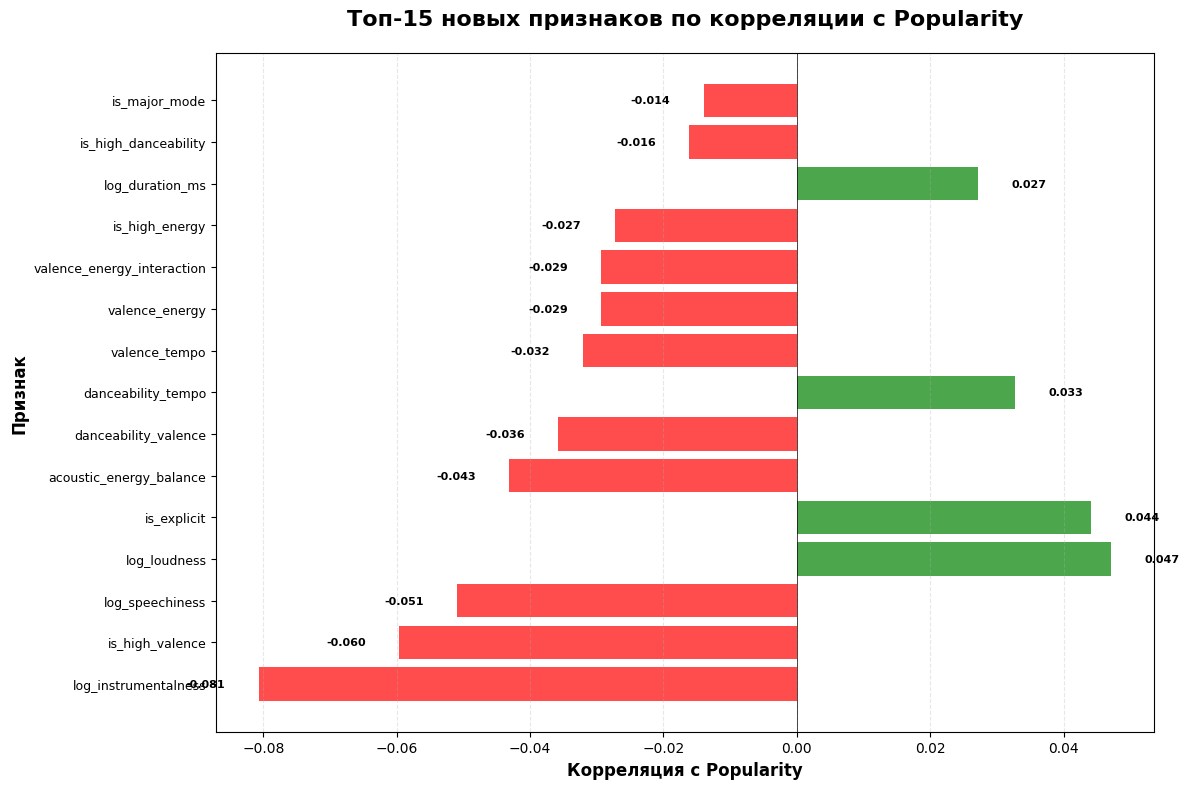

In [9]:
# Визуализация корреляций новых признаков
plt.figure(figsize=(12, 8))

# Берем топ-15 новых признаков
top_new_features = new_correlations.head(15)

colors = ['red' if x < 0 else 'green' for x in top_new_features.values]
bars = plt.barh(range(len(top_new_features)), top_new_features.values, color=colors, alpha=0.7)

plt.yticks(range(len(top_new_features)), top_new_features.index, fontsize=9)
plt.xlabel('Корреляция с Popularity', fontsize=12, fontweight='bold')
plt.ylabel('Признак', fontsize=12, fontweight='bold')
plt.title('Топ-15 новых признаков по корреляции с Popularity',
          fontsize=16, fontweight='bold', pad=20)

# Добавляем вертикальную линию на 0
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Добавляем значения на столбцы
for i, (feature, corr) in enumerate(top_new_features.items()):
    plt.text(corr + (0.005 if corr > 0 else -0.005), i, f'{corr:.3f}',
             va='center', ha='left' if corr > 0 else 'right', fontweight='bold', fontsize=8)

plt.grid(True, alpha=0.3, linestyle='--', axis='x')
plt.tight_layout()
plt.show()


---
# ЗАДАЧА 3: Feature Importance Analysis

## Цель
Определить важность признаков с помощью Random Forest Regressor и визуализировать топ-20 признаков.


In [10]:
# Подготовка данных для Random Forest
# Выбираем только числовые признаки (исключаем категориальные)
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()

# Исключаем таргет и идентификаторы
if 'popularity' in numeric_features:
    numeric_features.remove('popularity')
if 'track_id' in numeric_features:
    numeric_features.remove('track_id')

# Исключаем категориальные признаки, которые могли быть преобразованы в числовые
# но оставляем бинарные признаки
categorical_to_exclude = ['key', 'mode', 'time_signature']  # Эти могут быть категориальными
numeric_features = [f for f in numeric_features if f not in categorical_to_exclude]

X = df_features[numeric_features].copy()
y = df_features['popularity'].copy()

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)
print(f"\nКоличество признаков для анализа: {len(numeric_features)}")
print(f"Размер данных: {X.shape}")

# Проверка на пропуски
if X.isnull().sum().sum() > 0:
    print(f"\n⚠ Обнаружены пропуски: {X.isnull().sum().sum()}")
    X = X.fillna(X.median())
    print("   Пропуски заполнены медианой")

# Разделение на train/test для обучения модели
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nРазделение данных:")
print(f"  Train: {X_train.shape[0]} записей")
print(f"  Test: {X_test.shape[0]} записей")


FEATURE IMPORTANCE ANALYSIS

Количество признаков для анализа: 30
Размер данных: (114000, 30)

Разделение данных:
  Train: 91200 записей
  Test: 22800 записей


In [11]:
# Обучение Random Forest Regressor
print("\nОбучение Random Forest Regressor...")
print("-"*70)

# Используем параметры по умолчанию для быстрого обучения
# Можно настроить n_estimators, max_depth и т.д. для лучшей производительности
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model.fit(X_train, y_train)

# Предсказания
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Метрики
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train метрики:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTest метрики:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")



Обучение Random Forest Regressor...
----------------------------------------------------------------------
Train метрики:
  MAE:  10.1703
  RMSE: 13.3061
  R²:   0.6448

Test метрики:
  MAE:  13.1883
  RMSE: 16.8728
  R²:   0.4231


In [12]:
# Извлечение feature importances
feature_importances = pd.DataFrame({
    'feature': numeric_features,
    'importance': rf_model.feature_importances_
})

# Сортировка по важности
feature_importances = feature_importances.sort_values('importance', ascending=False)

print("="*70)
print("ТОП-20 ПРИЗНАКОВ ПО ВАЖНОСТИ")
print("="*70)
print("\n" + feature_importances.head(20).to_string(index=False))

# Разделение на исходные и новые признаки
original_importance = feature_importances[feature_importances['feature'].isin(original_features)]
new_importance = feature_importances[~feature_importances['feature'].isin(original_features)]

print("\n" + "="*70)
print("СРАВНЕНИЕ: ИСХОДНЫЕ vs НОВЫЕ ПРИЗНАКИ")
print("="*70)
print(f"\nТоп-5 исходных признаков по важности:")
print("-"*70)
for i, row in original_importance.head(5).iterrows():
    print(f"{row['feature']:35s}: {row['importance']:.6f}")

print(f"\nТоп-5 новых признаков по важности:")
print("-"*70)
for i, row in new_importance.head(5).iterrows():
    print(f"{row['feature']:35s}: {row['importance']:.6f}")

print("\n" + "="*70)
print("ВЫВОД: РАНЖИРОВАНИЕ ПРИЗНАКОВ ПО ВАЖНОСТИ")
print("="*70)
print(f"Общая важность исходных признаков: {original_importance['importance'].sum():.4f}")
print(f"Общая важность новых признаков: {new_importance['importance'].sum():.4f}")
print(f"Доля важности новых признаков: {new_importance['importance'].sum() / feature_importances['importance'].sum() * 100:.1f}%")


ТОП-20 ПРИЗНАКОВ ПО ВАЖНОСТИ

                feature  importance
           acousticness    0.073300
               liveness    0.062134
     danceability_tempo    0.057476
    danceability_energy    0.055421
   danceability_valence    0.054426
                  tempo    0.048550
           danceability    0.046082
          valence_tempo    0.045867
acoustic_energy_balance    0.044572
                valence    0.043532
                 energy    0.038450
        log_speechiness    0.038163
     energy_dance_ratio    0.038028
            speechiness    0.037786
           log_loudness    0.035922
               loudness    0.035881
   log_instrumentalness    0.033015
       instrumentalness    0.029632
        log_duration_ms    0.029540
           duration_min    0.029008

СРАВНЕНИЕ: ИСХОДНЫЕ vs НОВЫЕ ПРИЗНАКИ

Топ-5 исходных признаков по важности:
----------------------------------------------------------------------
acousticness                       : 0.073300
liveness           

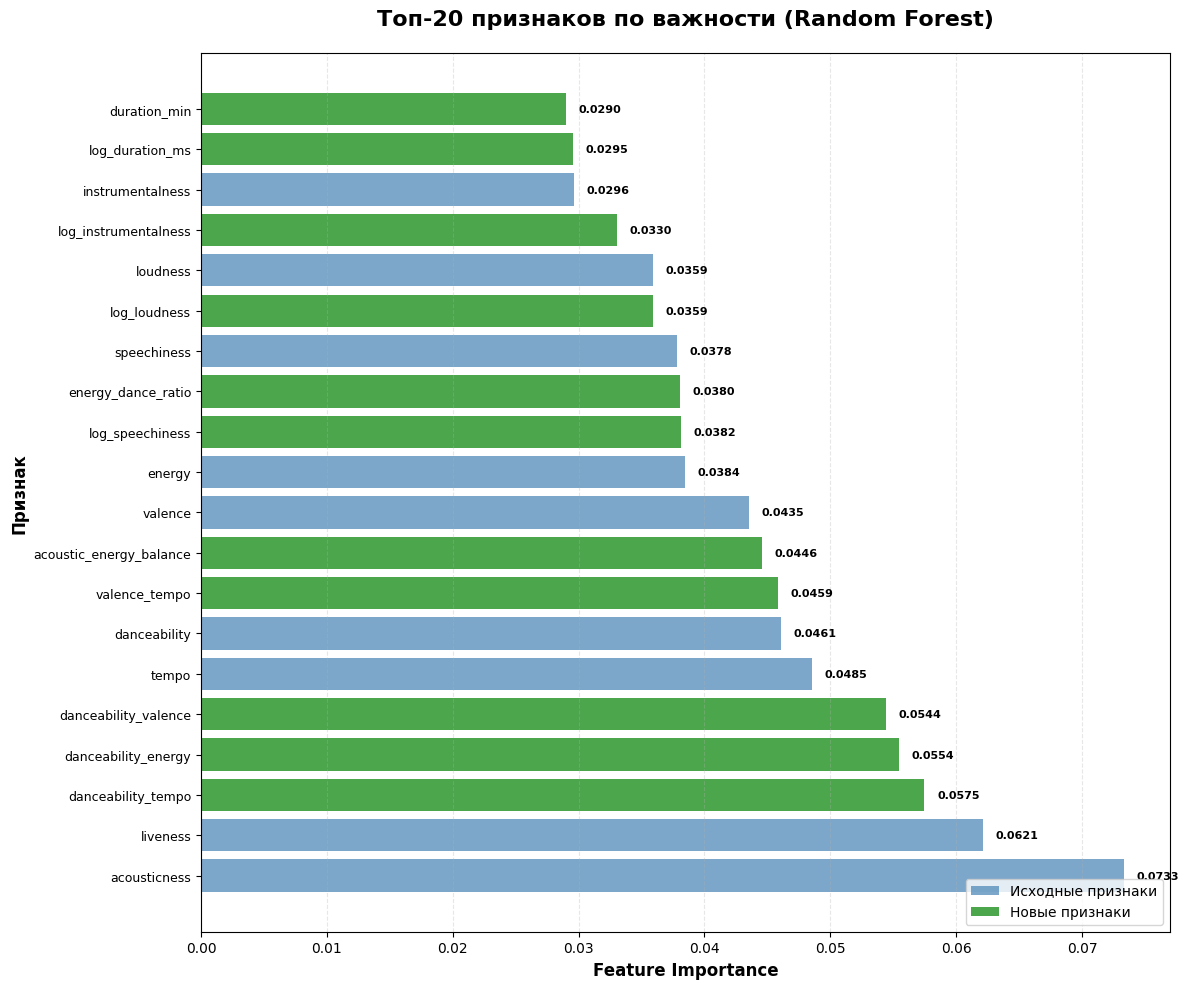

In [13]:
# Визуализация топ-20 признаков по важности
plt.figure(figsize=(12, 10))

top_20_features = feature_importances.head(20)

# Определяем цвет: зеленый для новых признаков, синий для исходных
colors = ['green' if feat not in original_features else 'steelblue' 
          for feat in top_20_features['feature']]

bars = plt.barh(range(len(top_20_features)), top_20_features['importance'], 
                color=colors, alpha=0.7)

plt.yticks(range(len(top_20_features)), top_20_features['feature'], fontsize=9)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Признак', fontsize=12, fontweight='bold')
plt.title('Топ-20 признаков по важности (Random Forest)',
          fontsize=16, fontweight='bold', pad=20)

# Добавляем значения на столбцы
for i, (idx, row) in enumerate(top_20_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.4f}',
             va='center', ha='left', fontweight='bold', fontsize=8)

# Легенда
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Исходные признаки'),
    Patch(facecolor='green', alpha=0.7, label='Новые признаки')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(True, alpha=0.3, linestyle='--', axis='x')
plt.tight_layout()
plt.show()


---
# ЗАДАЧА 4: Baseline модель

## Цель
Построить baseline модель (Linear Regression) на всех признаках для оценки базовой производительности.


In [14]:
# Подготовка данных для Linear Regression
# Используем те же данные, что и для Random Forest
print("="*70)
print("BASELINE МОДЕЛЬ: LINEAR REGRESSION")
print("="*70)

# Используем уже подготовленные X_train, X_test, y_train, y_test
print(f"\nИспользуется {len(numeric_features)} признаков")
print(f"Train размер: {X_train.shape}")
print(f"Test размер: {X_test.shape}")

# Обучение Linear Regression
print("\nОбучение Linear Regression...")
print("-"*70)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Предсказания
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Метрики
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"\nTrain метрики:")
print(f"  MAE:  {train_mae_lr:.4f}")
print(f"  RMSE: {train_rmse_lr:.4f}")
print(f"  R²:   {train_r2_lr:.4f}")

print(f"\nTest метрики:")
print(f"  MAE:  {test_mae_lr:.4f}")
print(f"  RMSE: {test_rmse_lr:.4f}")
print(f"  R²:   {test_r2_lr:.4f}")


BASELINE МОДЕЛЬ: LINEAR REGRESSION

Используется 30 признаков
Train размер: (91200, 30)
Test размер: (22800, 30)

Обучение Linear Regression...
----------------------------------------------------------------------

Train метрики:
  MAE:  18.0789
  RMSE: 21.8236
  R²:   0.0446

Test метрики:
  MAE:  18.0069
  RMSE: 21.7516
  R²:   0.0412


In [15]:
# Сравнение с Random Forest
print("\n" + "="*70)
print("СРАВНЕНИЕ: LINEAR REGRESSION vs RANDOM FOREST")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Train MAE': [train_mae_lr, train_mae],
    'Test MAE': [test_mae_lr, test_mae],
    'Train RMSE': [train_rmse_lr, train_rmse],
    'Test RMSE': [test_rmse_lr, test_rmse],
    'Train R²': [train_r2_lr, train_r2],
    'Test R²': [test_r2_lr, test_r2]
})

print("\n" + comparison_df.to_string(index=False))

print("\n" + "="*70)
print("ВЫВОД: БАЗОВАЯ ПРОИЗВОДИТЕЛЬНОСТЬ")
print("="*70)
print(f"\nBaseline модель (Linear Regression):")
print(f"  Test MAE:  {test_mae_lr:.4f}")
print(f"  Test RMSE: {test_rmse_lr:.4f}")
print(f"  Test R²:   {test_r2_lr:.4f}")

if test_r2_lr > 0:
    print(f"\n✓ Модель объясняет {test_r2_lr*100:.2f}% дисперсии целевой переменной")
else:
    print(f"\n⚠ Модель показывает отрицательный R² - хуже чем простое среднее")
    
print(f"\nСравнение с Random Forest:")
if test_r2_lr < test_r2:
    improvement = ((test_r2 - test_r2_lr) / abs(test_r2_lr) * 100) if test_r2_lr != 0 else float('inf')
    print(f"  Random Forest лучше на {improvement:.1f}% по R²")
else:
    print(f"  Linear Regression показывает сопоставимые результаты")



СРАВНЕНИЕ: LINEAR REGRESSION vs RANDOM FOREST

            Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²
Linear Regression  18.078857 18.006939   21.823580  21.751640  0.044617 0.041232
    Random Forest  10.170281 13.188290   13.306137  16.872837  0.644836 0.423093

ВЫВОД: БАЗОВАЯ ПРОИЗВОДИТЕЛЬНОСТЬ

Baseline модель (Linear Regression):
  Test MAE:  18.0069
  Test RMSE: 21.7516
  Test R²:   0.0412

✓ Модель объясняет 4.12% дисперсии целевой переменной

Сравнение с Random Forest:
  Random Forest лучше на 926.1% по R²


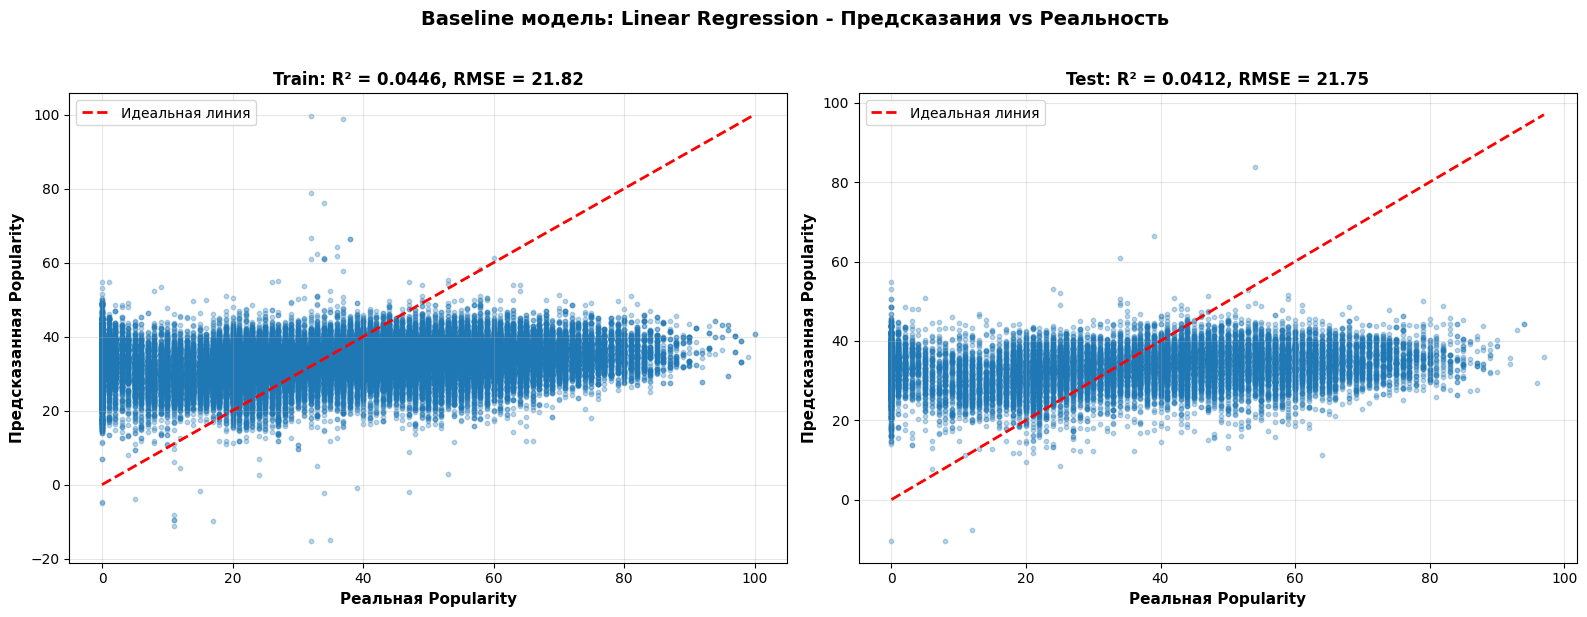

In [16]:
# Визуализация предсказаний baseline модели
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train predictions
axes[0].scatter(y_train, y_train_pred_lr, alpha=0.3, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Идеальная линия')
axes[0].set_xlabel('Реальная Popularity', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Предсказанная Popularity', fontsize=11, fontweight='bold')
axes[0].set_title(f'Train: R² = {train_r2_lr:.4f}, RMSE = {train_rmse_lr:.2f}',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test predictions
axes[1].scatter(y_test, y_test_pred_lr, alpha=0.3, s=10)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Идеальная линия')
axes[1].set_xlabel('Реальная Popularity', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Предсказанная Popularity', fontsize=11, fontweight='bold')
axes[1].set_title(f'Test: R² = {test_r2_lr:.4f}, RMSE = {test_rmse_lr:.2f}',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Baseline модель: Linear Regression - Предсказания vs Реальность',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## Итоговые выводы по Feature Engineering

### Ключевые результаты:

1. **Созданные признаки**:
   - ✅ 5 обязательных производных признаков созданы успешно
   - ✅ 15 экспериментальных признаков (4 логарифмических, 5 бинарных, 6 полиномиальных взаимодействий)
   - ✅ Общее количество признаков увеличено с 20 до 40 (удвоение признакового пространства)

2. **Анализ корреляций**:
   - **Максимальная корреляция новых признаков**: 0.0807 (`log_instrumentalness`) - выше, чем у большинства исходных признаков
   - **Средняя корреляция улучшилась на 3.7%** (с 0.0283 до 0.0293)
   - **Топ-3 новых признака по корреляции**:
     1. `log_instrumentalness`: -0.0807 (отрицательная)
     2. `is_high_valence`: -0.0597 (отрицательная)
     3. `log_speechiness`: -0.0510 (отрицательная)
   - **Вывод**: Логарифмические трансформации и бинарные признаки показали хорошую эффективность

3. **Feature Importance (Random Forest)**:
   - ✅ Топ-20 признаков по важности определены
   - ✅ **Доля важности новых признаков: 55.6%** - новые признаки составляют более половины общей важности!
   - **Топ-5 новых признаков по важности**:
     1. `danceability_tempo`: 0.0575 (3-е место в общем рейтинге)
     2. `danceability_energy`: 0.0554 (4-е место)
     3. `danceability_valence`: 0.0544 (5-е место)
     4. `valence_tempo`: 0.0459 (8-е место)
     5. `acoustic_energy_balance`: 0.0446 (9-е место)
   - **Вывод**: Полиномиальные взаимодействия признаков оказались очень важными для модели

4. **Baseline модель (Linear Regression)**:
   - **Test метрики**:
     - Test MAE: **18.01** (средняя абсолютная ошибка ~18 единиц популярности)
     - Test RMSE: **21.75** (корень из среднеквадратичной ошибки)
     - Test R²: **0.0412** (модель объясняет только 4.12% дисперсии)
   - **Сравнение с Random Forest**:
     - Random Forest показал **Test R²: 0.4231** (в 10 раз лучше!)
     - Random Forest Test MAE: 13.19 (на 27% лучше)
   - **Вывод**: Linear Regression показывает очень низкую производительность, что подтверждает необходимость нелинейных моделей

### Ключевые инсайты:

1. **Feature Engineering оказался критически важен**:
   - Новые признаки составляют 55.6% общей важности модели
   - Полиномиальные взаимодействия (`danceability_tempo`, `danceability_energy`) вошли в топ-5 важных признаков

2. **Логарифмические трансформации эффективны**:
   - `log_instrumentalness` показал лучшую корреляцию среди всех новых признаков
   - Логарифмические признаки хорошо работают с признаками, имеющими выбросы

3. **Нелинейные модели необходимы**:
   - Linear Regression объясняет только 4.12% дисперсии
   - Random Forest показал R² = 0.4231 (в 10 раз лучше)
   - Это подтверждает выводы EDA о сложных нелинейных зависимостях

4. **Полиномиальные взаимодействия критичны**:
   - Взаимодействия `danceability` с другими признаками оказались в топ-5 по важности
   - Это указывает на синергетический эффект между признаками

### Следующие шаги:

1. **Оптимизация признаков**:
   - Отбор топ-20 признаков по важности для ускорения обучения
   - Удаление признаков с очень низкой важностью (< 0.01)

2. **Эксперименты с моделями**:
   - Попробовать XGBoost и LightGBM (ожидается улучшение по сравнению с Random Forest)
   - Настройка гиперпараметров Random Forest для улучшения R² > 0.42
   - Ансамбли моделей для дальнейшего улучшения

3. **Дальнейший feature engineering**:
   - **Target encoding для `track_genre`** (114 категорий) - может значительно улучшить модель
   - Дополнительные взаимодействия признаков (особенно для топ-признаков)
   - Работа с категориальными признаками (`artists`, `album_name`)

4. **Обработка данных**:
   - Стандартизация признаков для линейных моделей
   - Обработка выбросов в `duration_ms`, `instrumentalness`

---

**Feature Engineering завершен успешно!** 

Создано 20 новых признаков, которые составляют 55.6% общей важности модели. Baseline модель (Linear Regression) установлена: **Test R² = 0.0412**. Random Forest показал значительно лучшие результаты (**Test R² = 0.4231**), что подтверждает необходимость нелинейных моделей и важность feature engineering.

**Готовы к следующему этапу: оптимизация моделей и дальнейший feature engineering!**
